# Création et optimisation de l'algorithme de regression du modèle de machine learning  

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Dict, Tuple

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, MaxAbsScaler, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [207]:
def big_fit(X_train, y_train, X_test, y_test, transformer):
    estimators = [
        ('gbr', GradientBoostingRegressor(random_state=42)),
        ("dtr", DecisionTreeRegressor(random_state=42)),
        ("rfr", RandomForestRegressor(random_state=42)),
    ]

    default_error = dict()

    for estimator in estimators:
        pipe = Pipeline(steps=[("transformer", transformer), estimator])
        pipe.fit(X_train, y_train)
        
        y_pred = pipe.predict(X_test)
        mea_score = mean_absolute_error(y_test, y_pred)
        mse_score = mean_squared_error(y_test, y_pred)
        medae_score =  median_absolute_error(y_test, y_pred)
        r2score = r2_score(y_test, y_pred)
        name = estimator[0]
        default_error[name] = {'mea' :mea_score, 'mse': mse_score, 'medae': medae_score, 'r2': r2score}

    param_grids = [
        {
            "gbr__n_estimators": [200, 300],
            "gbr__min_samples_split": np.arange(2, 5),
            "gbr__min_samples_leaf": np.arange(1, 4),
            "gbr__max_features": ["sqrt", "log2", 0.2, 0.3, 0.4],

        },
        {
            "dtr__min_samples_split": np.arange(2, 5),
            "dtr__min_samples_leaf": np.arange(1, 4),
            "dtr__max_features": ["sqrt", "log2", 0.2, 0.3, 0.4],
        },
        {
            "rfr__n_estimators": [200, 300],
            "rfr__min_samples_split": np.arange(2, 5),
            "rfr__min_samples_leaf": np.arange(1, 4),
            "rfr__max_features": ["sqrt", "log2", 0.2, 0.3, 0.4],
        },
    ]

    best_estimators = dict()
    best_params = dict()
    best_scores = dict()
    predict_error = dict()
    error = dict()

    for estimator, param_grid in zip(estimators, param_grids):
        grid = GridSearchCV(
            Pipeline(steps=[("transformer", transformer), estimator]),
            param_grid,
            cv=5,
            scoring="r2",
            return_train_score=True,
            verbose=1,
            n_jobs=-1,
        )
        name = estimator[0]
        print(f"Trainning with {name}")
        grid.fit(X_train, y_train)
        best_estimators[name] = grid.best_estimator_
        best_params[name] = grid.best_params_
        best_scores[name] = round(grid.best_score_ * 100, 2)
        
        y_pred = grid.predict(X_test)
        mea_score = mean_absolute_error(y_test, y_pred)
        mse_score = mean_squared_error(y_test, y_pred)
        medae_score =  median_absolute_error(y_test, y_pred)
        r2score = r2_score(y_test, y_pred)
        predict_error[name] = {'mea' :mea_score, 'mse': mse_score, 'medae': medae_score, 'r2': r2score}
        error[name] = [abs(x-y) for x,y in zip(y_test, y_pred)]
    
    return default_error, best_scores, error, predict_error, best_params, best_estimators

In [208]:
def plot_learning_curve(name, model, X_train, y_train):
    print(f"Computing learning curve of {name}")
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train,
        y_train,
        train_sizes=np.linspace(0.1, 1, 20),
        cv=5,
        random_state=42,
        scoring='r2'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.title(f"Learning Curve with {name}")
    plt.xlabel("Train size")
    plt.ylabel("Score")
    plt.ylim(0.6, 1)

    plt.plot(train_sizes, train_scores_mean, label="Training score")
    plt.plot(train_sizes, test_scores_mean, label="Cross validation score")
    plt.legend()

    plt.show()

## Choix des algorithmes de régression et des transformeurs

In [209]:
house_price_brute = pd.read_csv('Data/train.csv')
house_price_brute = house_price_brute.set_index('Id')
house_price_brute.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Test avec SimpleImputer

In [210]:
df_train_numerical = [column for column in house_price_brute.columns.values.tolist() if house_price_brute[column].dtype != object]
df_train_numerical.remove('SalePrice')
df_train_categorical = [column for column in house_price_brute.columns.values.tolist() if house_price_brute[column].dtype == object]

In [211]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('robust', RobustScaler()),
])


transformer = ColumnTransformer(transformers=[
        ('num', num_transformer, df_train_numerical),
        ('cat', cat_transformer, df_train_categorical)
])

df_train_X, df_train_y = (house_price_brute.drop(["SalePrice"], axis=1), house_price_brute["SalePrice"])
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_train_X, df_train_y, test_size=0.25, random_state=42)
default_error, best_scores, error, predict_error, best_params, best_estimators = big_fit(X_train_base, y_train_base, X_test_base, y_test_base, transformer)
result_wo_name = pd.DataFrame({
    "Name": [e for e in best_estimators.keys()],
    "Default mea test score": [val['mea'] for val in default_error.values()],
    "Default mse test score": [val['mse'] for val in default_error.values()],
    "Default medae test score": [val['medae'] for val in default_error.values()],
    "Default r2 test score": [val['r2'] for val in default_error.values()],
    "Grid cross-val score": list(best_scores.values()),
    "Grid mea test score": [val['mea'] for val in predict_error.values()],
    "Grid mse test score": [val['mse'] for val in predict_error.values()],
    "Grid medae test score": [val['medae'] for val in predict_error.values()],
    "Grid r2 test score": [val['r2'] for val in predict_error.values()],
})
print("Train Finished! \o/")

Trainning with gbr
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Trainning with dtr
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Trainning with rfr
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Train Finished! \o/


In [212]:
result_wo_name

,Name,Default mea test score,Default mse test score,Default medae test score,Default r2 test score,Grid cross-val score,Grid mea test score,Grid mse test score,Grid medae test score,Grid r2 test score
0,gbr,16085.085021,6.222767e+08,10834.035784,0.911171,82.71,15470.986999,6.008686e+08,9996.873674,0.914227
1,dtr,26526.657534,1.666593e+09,16500.000000,0.762096,69.82,24176.619178,1.628107e+09,15300.000000,0.767590
2,rfr,17147.261123,7.683908e+08,10176.360000,0.890313,82.64,16292.465723,7.603112e+08,10050.075517,0.891466


In [213]:
for k, v in best_params.items():
    print(f"{k}: ", end="")
    print(" ; ".join(f"{p.split('__')[1]}: {pv}" for p, pv in v.items()))

gbr: max_features: sqrt ; min_samples_leaf: 1 ; min_samples_split: 2 ; n_estimators: 300
dtr: max_features: 0.4 ; min_samples_leaf: 1 ; min_samples_split: 3
rfr: max_features: 0.3 ; min_samples_leaf: 3 ; min_samples_split: 2 ; n_estimators: 300


Computing learning curve of gbr


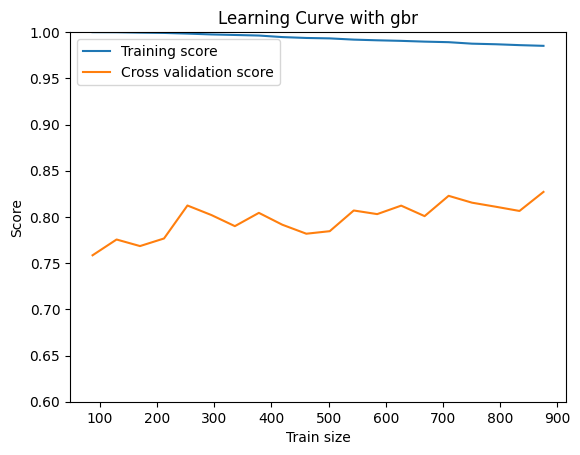

In [214]:
plot_learning_curve('gbr', best_estimators['gbr'], X_train_base, y_train_base)

Computing learning curve of rfr


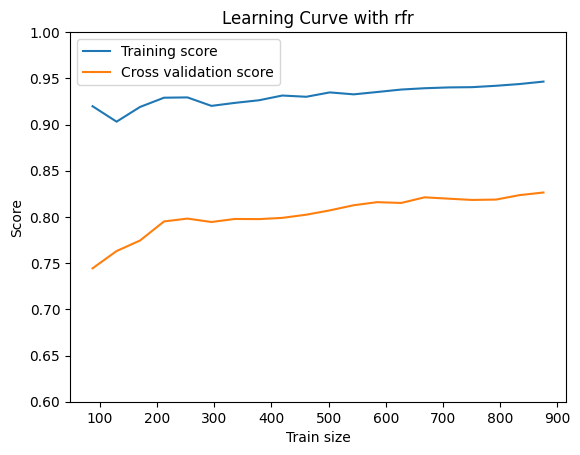

In [215]:
plot_learning_curve('rfr', best_estimators['rfr'], X_train_base, y_train_base)

Les learning curves pour le gradiantboosting et le randomforest nous montre que l'algorithme réagit le mieux lorsque le nombre de données d'entrainement est très important.  
Celle du gradiantboosting quant à elle fait de l'overfitting lorsque les données d'entraînement sont trop peu nombreuses. 

### Test remplissage main

In [216]:
house_price_fillm = house_price_brute.copy()
house_price_fillm

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [217]:
house_price_fillm['GarageYrBlt'].fillna(2022, inplace=True)
house_price_fillm = house_price_fillm.astype({'GarageYrBlt': int})
house_price_fillm['GarageYrBlt'] = house_price_fillm['GarageYrBlt'].apply(lambda x : 2022-x)
house_price_fillm.rename(columns={'GarageYrBlt': 'GarageAge'}, inplace=True)
house_price_fillm['LotFrontage'].fillna(0, inplace=True)
house_price_fillm['MasVnrArea'].fillna(0, inplace=True)
house_price_fillm['MasVnrType'].fillna('none', inplace=True)
house_price_fillm['Electrical'].fillna('SBrkr', inplace=True)

In [218]:
colonne_conversion = [
    'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
    'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
    'ScreenPorch', 'PoolArea'
]
for i in colonne_conversion :
    house_price_fillm[i] = house_price_fillm[i].apply(lambda x: x*0.0929)

house_price_fillm['LotFrontage'] = house_price_fillm['LotFrontage'].apply(lambda x:x/3.2808)

In [219]:
liste_colonne = [
    "Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"
]

for i in liste_colonne : 
    house_price_fillm[i].fillna('NA', inplace=True)

In [220]:
df_train_numerical = [column for column in house_price_fillm.columns.values.tolist() if house_price_fillm[column].dtype != object]
df_train_numerical.remove('SalePrice')
df_train_categorical = [column for column in house_price_fillm.columns.values.tolist() if house_price_fillm[column].dtype == object]

transformer = make_column_transformer(
    (RobustScaler(), df_train_numerical),
    (OneHotEncoder(handle_unknown="infrequent_if_exist"), df_train_categorical)
)

df_train_X, df_train_y = (house_price_fillm.drop(["SalePrice"], axis=1), house_price_fillm["SalePrice"])
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_train_X, df_train_y, test_size=0.25, random_state=42)
default_error, best_scores, error, predict_error, best_params, best_estimators = big_fit(X_train_base, y_train_base, X_test_base, y_test_base, transformer)
result_wo_name = pd.DataFrame({
    "Name": [e for e in best_estimators.keys()],
    "Default mea test score": [val['mea'] for val in default_error.values()],
    "Default mse test score": [val['mse'] for val in default_error.values()],
    "Default medae test score": [val['medae'] for val in default_error.values()],
    "Default r2 test score": [val['r2'] for val in default_error.values()],
    "Grid cross-val score": list(best_scores.values()),
    "Grid mea test score": [val['mea'] for val in predict_error.values()],
    "Grid mse test score": [val['mse'] for val in predict_error.values()],
    "Grid medae test score": [val['medae'] for val in predict_error.values()],
    "Grid r2 test score": [val['r2'] for val in predict_error.values()],
})
print("Train Finished! \o/")

Trainning with gbr
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Trainning with dtr
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Trainning with rfr
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Train Finished! \o/


In [221]:
result_wo_name

,Name,Default mea test score,Default mse test score,Default medae test score,Default r2 test score,Grid cross-val score,Grid mea test score,Grid mse test score,Grid medae test score,Grid r2 test score
0,gbr,16224.267797,6.970376e+08,11221.686914,0.900499,82.47,15506.858131,6.293141e+08,10151.539923,0.910166
1,dtr,25947.323288,1.524137e+09,16400.000000,0.782431,66.26,26317.194521,1.720607e+09,17333.333333,0.754385
2,rfr,17081.780247,7.630422e+08,9930.570000,0.891077,82.90,16005.834589,7.276491e+08,9382.482798,0.896129


In [222]:
for k, v in best_params.items():
    print(f"{k}: ", end="")
    print(" ; ".join(f"{p.split('__')[1]}: {pv}" for p, pv in v.items()))

gbr: max_features: 0.2 ; min_samples_leaf: 2 ; min_samples_split: 2 ; n_estimators: 300
dtr: max_features: 0.4 ; min_samples_leaf: 2 ; min_samples_split: 2
rfr: max_features: 0.2 ; min_samples_leaf: 2 ; min_samples_split: 2 ; n_estimators: 200


Le remplissage des doonées par un SimpleImputer ou par réflexion sur chaque colonne donne une évolution des résultats disparate.  
Ainsi, le gradientboosting préfère la stratégie most_frequent_use du SimpleImputeur alors que le randomforest préfère le remplissage à la main. 

### Effet du drop colonne

On va drop l'ensemble des colonnes dont la magnitude sur le prix de vente de la matrice de corrélation est comprise entre [-0.2, 0.2].

In [223]:
house_price_drop = house_price_fillm.copy()


In [224]:
list_drop = [
    "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "PoolQC", "Fence", "SaleCondition", "YrSold", "MoSold", "MiscFeature", "MiscVal", "BedroomAbvGr",
    "KitchenAbvGr", "BsmtHalfBath", "LowQualFinSF", "Heating", "BsmtFinSF2", "BsmtFinType2", "ExterCond", "RoofMatl", "OverallCond", "HouseStyle", "BldgType",
    "Condition2", "Condition1", "Neighborhood", "LandSlope", "LotConfig", "Utilities", "LandContour", "Alley", "Street", "MSSubClass"
]

for i in list_drop :
    house_price_drop.drop([i], axis='columns', inplace=True)

In [225]:
df_train_numerical = [column for column in house_price_drop.columns.values.tolist() if house_price_drop[column].dtype != object]
df_train_numerical.remove('SalePrice')
df_train_categorical = [column for column in house_price_drop.columns.values.tolist() if house_price_drop[column].dtype == object]

transformer = make_column_transformer(
    (RobustScaler(), df_train_numerical),
    (OneHotEncoder(handle_unknown="infrequent_if_exist"), df_train_categorical)
)

df_train_X, df_train_y = (house_price_drop.drop(["SalePrice"], axis=1), house_price_drop["SalePrice"])
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_train_X, df_train_y, test_size=0.25, random_state=42)
default_error, best_scores, error, predict_error, best_params, best_estimators = big_fit(X_train_base, y_train_base, X_test_base, y_test_base, transformer)
result_wo_name = pd.DataFrame({
    "Name": [e for e in best_estimators.keys()],
    "Default mea test score": [val['mea'] for val in default_error.values()],
    "Default mse test score": [val['mse'] for val in default_error.values()],
    "Default medae test score": [val['medae'] for val in default_error.values()],
    "Default r2 test score": [val['r2'] for val in default_error.values()],
    "Grid cross-val score": list(best_scores.values()),
    "Grid mea test score": [val['mea'] for val in predict_error.values()],
    "Grid mse test score": [val['mse'] for val in predict_error.values()],
    "Grid medae test score": [val['medae'] for val in predict_error.values()],
    "Grid r2 test score": [val['r2'] for val in predict_error.values()],
})
print("Train Finished! \o/")

Trainning with gbr
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Trainning with dtr
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Trainning with rfr
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Train Finished! \o/


In [226]:
result_wo_name

,Name,Default mea test score,Default mse test score,Default medae test score,Default r2 test score,Grid cross-val score,Grid mea test score,Grid mse test score,Grid medae test score,Grid r2 test score
0,gbr,17042.227446,7.599973e+08,11087.773457,0.891511,79.88,17311.181266,7.147834e+08,11463.764332,0.897965
1,dtr,25765.369863,1.553369e+09,16000.000000,0.778258,71.00,27067.502740,1.834101e+09,16200.000000,0.738184
2,rfr,17159.730411,7.381142e+08,9840.170000,0.894635,82.31,16667.176118,8.104900e+08,9834.294552,0.884303


In [227]:
for k, v in best_params.items():
    print(f"{k}: ", end="")
    print(" ; ".join(f"{p.split('__')[1]}: {pv}" for p, pv in v.items()))

gbr: max_features: 0.4 ; min_samples_leaf: 2 ; min_samples_split: 2 ; n_estimators: 300
dtr: max_features: 0.3 ; min_samples_leaf: 1 ; min_samples_split: 3
rfr: max_features: 0.3 ; min_samples_leaf: 3 ; min_samples_split: 2 ; n_estimators: 300


La perte d'un certain nombre de colonnes ont réduit le grid search cv score donc, il se peut que parmi ces colonnes certaines ont une importance, après transformations, plus importante que prévu.

In [228]:
def transfo_fit(X_train, y_train, X_test, y_test, df_train_numerical, df_train_categorical):
    
    estimator = ('gbr', GradientBoostingRegressor(random_state=42))

    transformers ={
        "Rob+One": make_column_transformer(
        (RobustScaler(), df_train_numerical),
        (OneHotEncoder(handle_unknown="infrequent_if_exist"), df_train_categorical)),
        "Rob+Ord": make_column_transformer(
        (RobustScaler(), df_train_numerical),
        (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), df_train_categorical)),
        "Min+One": make_column_transformer(
        (MinMaxScaler(), df_train_numerical),
        (OneHotEncoder(handle_unknown="infrequent_if_exist"), df_train_categorical)),
        "Max+One": make_column_transformer(
        (MaxAbsScaler(), df_train_numerical),
        (OneHotEncoder(handle_unknown="infrequent_if_exist"), df_train_categorical)),
        "Std+One": make_column_transformer(
        (StandardScaler(), df_train_numerical),
        (OneHotEncoder(handle_unknown="infrequent_if_exist"), df_train_categorical)),
    } 

    default_error = dict()

    for key, value in transformers.items():
        X_train_in = X_train.copy()
        X_test_in = X_test.copy()
        pipe = Pipeline(steps=[("transformer", value), estimator])
        pipe.fit(X_train_in, y_train)
        
        y_pred = pipe.predict(X_test_in)
        mea_score = mean_absolute_error(y_test, y_pred)
        mse_score = mean_squared_error(y_test, y_pred)
        medae_score =  median_absolute_error(y_test, y_pred)
        r2score = r2_score(y_test, y_pred)
        name = key
        default_error[name] = {'mea' :mea_score, 'mse': mse_score, 'medae': medae_score, 'r2': r2score}

    param_grid ={
        "gbr__n_estimators": [200, 300],
        "gbr__min_samples_split": np.arange(2, 5),
        "gbr__min_samples_leaf": np.arange(1, 4),
        "gbr__max_features": ["sqrt", "log2", 0.2, 0.3, 0.4],
    }

    best_estimators = dict()
    best_params = dict()
    best_scores = dict()
    predict_error = dict()
    error = dict()

    for key, value in transformers.items() :
        X_train_in = X_train.copy()
        X_test_in = X_test.copy()
        grid = GridSearchCV(
            Pipeline(steps=[("transformer", value), estimator]),
            param_grid,
            cv=5,
            scoring="r2",
            return_train_score=True,
            verbose=1,
            n_jobs=-1,
        )
        name = key
        print(f"Trainning with {name}")
        grid.fit(X_train_in, y_train)
        best_estimators[name] = grid.best_estimator_
        best_params[name] = grid.best_params_
        best_scores[name] = round(grid.best_score_ * 100, 2)
        
        y_pred = grid.predict(X_test_in)
        mea_score = mean_absolute_error(y_test, y_pred)
        mse_score = mean_squared_error(y_test, y_pred)
        medae_score =  median_absolute_error(y_test, y_pred)
        r2score = r2_score(y_test, y_pred)
        predict_error[name] = {'mea' :mea_score, 'mse': mse_score, 'medae': medae_score, 'r2': r2score}
        error[name] = [abs(x-y) for x,y in zip(y_test, y_pred)]
    
    return default_error, best_scores, error, predict_error, best_params, best_estimators

In [229]:
df_train_numerical = [column for column in house_price_fillm.columns.values.tolist() if house_price_fillm[column].dtype != object]
df_train_numerical.remove('SalePrice')
df_train_categorical = [column for column in house_price_fillm.columns.values.tolist() if house_price_fillm[column].dtype == object]

df_train_X, df_train_y = (house_price_fillm.drop(["SalePrice"], axis=1), house_price_fillm["SalePrice"])
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_train_X, df_train_y, test_size=0.25, random_state=42)
default_error, best_scores, error, predict_error, best_params, best_estimators = transfo_fit(X_train_base, y_train_base, X_test_base, y_test_base, df_train_numerical, df_train_categorical)
result_wo_name = pd.DataFrame({
    "Name": [e for e in best_estimators.keys()],
    "Default mea test score": [val['mea'] for val in default_error.values()],
    "Default mse test score": [val['mse'] for val in default_error.values()],
    "Default medae test score": [val['medae'] for val in default_error.values()],
    "Default r2 test score": [val['r2'] for val in default_error.values()],
    "Grid cross-val score": list(best_scores.values()),
    "Grid mea test score": [val['mea'] for val in predict_error.values()],
    "Grid mse test score": [val['mse'] for val in predict_error.values()],
    "Grid medae test score": [val['medae'] for val in predict_error.values()],
    "Grid r2 test score": [val['r2'] for val in predict_error.values()],
})
print("Train Finished! \o/")

Trainning with Rob+One
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Trainning with Rob+Ord
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Trainning with Min+One
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Trainning with Max+One
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Trainning with Std+One
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Train Finished! \o/


In [230]:
result_wo_name

,Name,Default mea test score,Default mse test score,Default medae test score,Default r2 test score,Grid cross-val score,Grid mea test score,Grid mse test score,Grid medae test score,Grid r2 test score
0,Rob+One,16224.267797,6.970376e+08,11221.686914,0.900499,82.47,15506.858131,6.293141e+08,10151.539923,0.910166
1,Rob+Ord,16308.122339,6.916871e+08,10407.384194,0.901262,81.71,15256.045124,6.795114e+08,9479.498847,0.903001
2,Min+One,16122.386197,6.645418e+08,11180.641490,0.905137,82.54,15103.567156,6.169871e+08,9934.776768,0.911926
3,Max+One,16201.547860,6.734415e+08,11221.686914,0.903867,82.54,15118.700709,6.176623e+08,9934.776768,0.911829
4,Std+One,16079.724149,6.673125e+08,11180.641490,0.904742,82.37,15514.465348,6.304466e+08,10151.539923,0.910004


Les résultats nous montre que les différences entre scaler sont minimes mais le scaler opti serait MinMaxScaler.
Pour le cas de l'encoder, deux métriques sont en faveur du OneHotEncoder (mse et r²) et les deux autres (mae et medae) sont en faveur du OrdinalEncoder.

Pour la suite des gridsearch on va donc utiliser le OneHotEncoder et le MinMaxscaler.

Pour des raisons de manque de puissance et donc des fontions big_fit qui prennet beaucoup de temps, je réduis le nombre de fit pour chaque algorithme.  
De plus, je retire le DecisionTree car inférieur aux GradientBoosting et RandomForest sur les résultats.

In [231]:
def big_fit_def(X_train, y_train, X_test, y_test):
    estimators = [
        ('gbr', GradientBoostingRegressor(random_state=42)),
        ("rfr", RandomForestRegressor(random_state=42)),
    ]

    default_errors = dict()

    for estimator in estimators:
        model = estimator[1]
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        mea_score = mean_absolute_error(y_test, y_pred)
        mse_score = mean_squared_error(y_test, y_pred)
        medae_score =  median_absolute_error(y_test, y_pred)
        r2score = r2_score(y_test, y_pred)
        name = estimator[0]
        default_errors[name] = {'mea' :mea_score, 'mse': mse_score, 'medae': medae_score, 'r2': r2score}

    param_grids = [
        {
            "n_estimators": np.arange(100, 400, 100),
        },
        {
            "n_estimators": np.arange(100, 400, 100),
        },
    ]

    best_estimators = dict()
    best_params = dict()
    best_scores = dict()
    predict_errors = dict()
    errors = dict()

    for estimator, param_grid in zip(estimators, param_grids):
        grid = GridSearchCV(
            estimator[1],
            param_grid,
            cv=5,
            scoring="r2",
            return_train_score=True,
            verbose=1,
            n_jobs=8,
        )
        name = estimator[0]
        print(f"Trainning with {name}")
        grid.fit(X_train, y_train)
        best_estimators[name] = grid.best_estimator_
        best_params[name] = grid.best_params_
        best_scores[name] = round(grid.best_score_ * 100, 2)
        
        y_pred = grid.predict(X_test)
        mea_score = mean_absolute_error(y_test, y_pred)
        mse_score = mean_squared_error(y_test, y_pred)
        medae_score =  median_absolute_error(y_test, y_pred)
        r2score = r2_score(y_test, y_pred)
        predict_errors[name] = {'mea' :mea_score, 'mse': mse_score, 'medae': medae_score, 'r2': r2score}
        errors[name] = [abs(x-y)/x for x,y in zip(y_test, y_pred)]
    
    return default_errors, best_scores, errors, predict_errors, best_params, best_estimators

In [232]:
df_train_numerical = [column for column in house_price_fillm.columns.values.tolist() if house_price_fillm[column].dtype != object]
df_train_numerical.remove('SalePrice')
df_train_categorical = [column for column in house_price_fillm.columns.values.tolist() if house_price_fillm[column].dtype == object]

transformer = make_column_transformer(
    (MinMaxScaler(), df_train_numerical),
    (OneHotEncoder(handle_unknown="infrequent_if_exist"), df_train_categorical)
)

df_train_X, df_train_y = (house_price_fillm.drop(["SalePrice"], axis=1), house_price_fillm["SalePrice"])
df_train_X_enc = transformer.fit_transform(df_train_X)

trans_features = transformer.get_feature_names_out()
print(f"{trans_features.size} features after trans")

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_train_X_enc, df_train_y, test_size=0.25, random_state=42)
default_errors, best_scores, errors, predict_errors, best_params, best_estimators = big_fit_def(X_train_base, y_train_base, X_test_base, y_test_base)

result_initial_comparaison = pd.DataFrame({
    "Name": [e for e in best_estimators.keys()],
    "Default mea test score": [val['mea'] for val in default_errors.values()],
    "Default mse test score": [val['mse'] for val in default_errors.values()],
    "Default medae test score": [val['medae'] for val in default_errors.values()],
    "Default r2 test score": [val['r2'] for val in default_errors.values()],
    "Grid cross-val score": list(best_scores.values()),
    "Grid mea test score": [val['mea'] for val in predict_errors.values()],
    "Grid mse test score": [val['mse'] for val in predict_errors.values()],
    "Grid medae test score": [val['medae'] for val in predict_errors.values()],
    "Grid r2 test score": [val['r2'] for val in predict_errors.values()],
})
print("Train Finished! \o/")

303 features after trans
Trainning with gbr
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Trainning with rfr
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Train Finished! \o/


In [233]:
result_initial_comparaison

,Name,Default mea test score,Default mse test score,Default medae test score,Default r2 test score,Grid cross-val score,Grid mea test score,Grid mse test score,Grid medae test score,Grid r2 test score
0,gbr,16283.708300,6.686908e+08,11503.16545,0.904545,79.82,15470.692377,6.547152e+08,10083.796137,0.906540
1,rfr,16983.883397,7.604994e+08,10237.50000,0.891440,80.64,16729.303288,7.316990e+08,9702.393333,0.895551


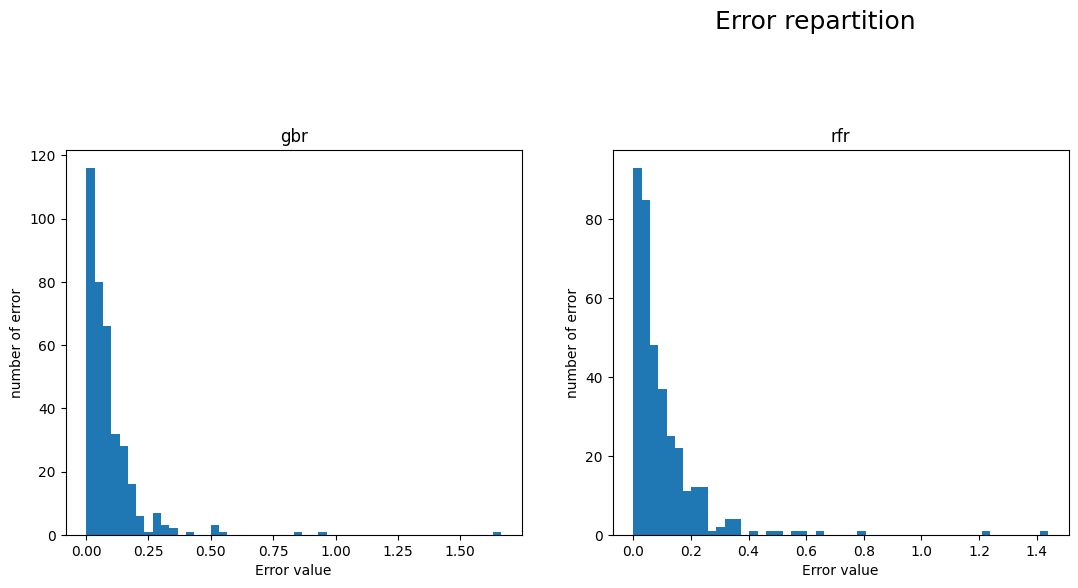

In [234]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Error repartition", fontsize=18, y=0.95)

i = 1
for name, error in errors.items():
    
    plt.subplot(3, 3, i)
    i += 1
    plt.title(f"{name}")
    plt.xlabel("Error value")
    plt.ylabel("number of error")

    plt.hist(error, bins=50)


plt.show()

Pour les deux modèles de régression, la majorité des erreurs sont en dessous de 20% cependant, on voit sur les courbes de répartition des erreurs qu'il existe des prédictions abhérentes.  

<AxesSubplot: xlabel='features'>

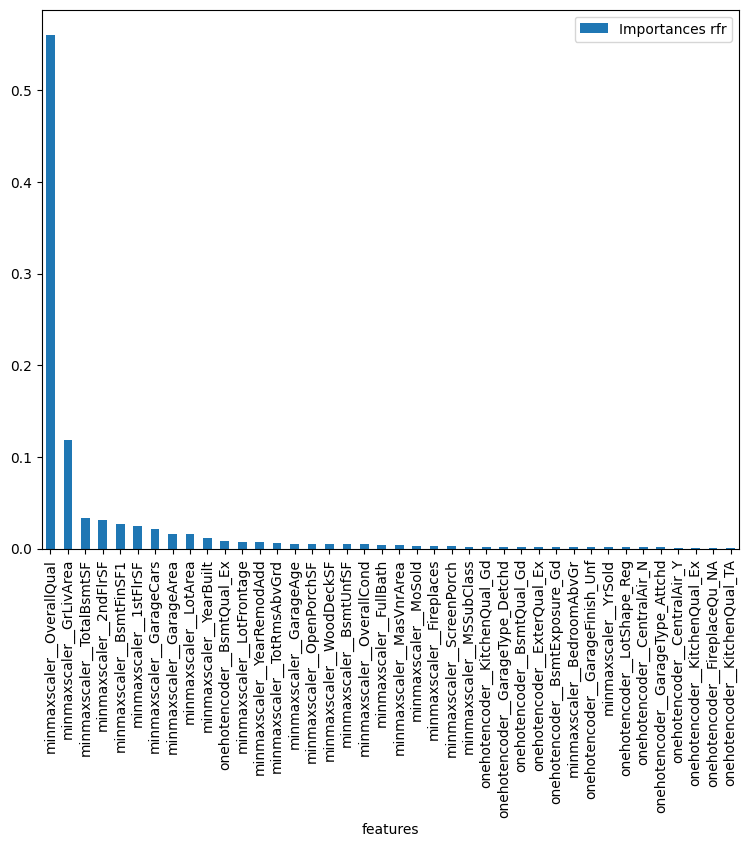

In [235]:
feature = pd.DataFrame(zip(trans_features, best_estimators['rfr'].feature_importances_), columns=['features', 'Importances rfr'])

feature.sort_values(by="Importances rfr", ascending=False).head(40).plot(x="features", kind='bar', figsize=(9, 7))

<AxesSubplot: xlabel='features'>

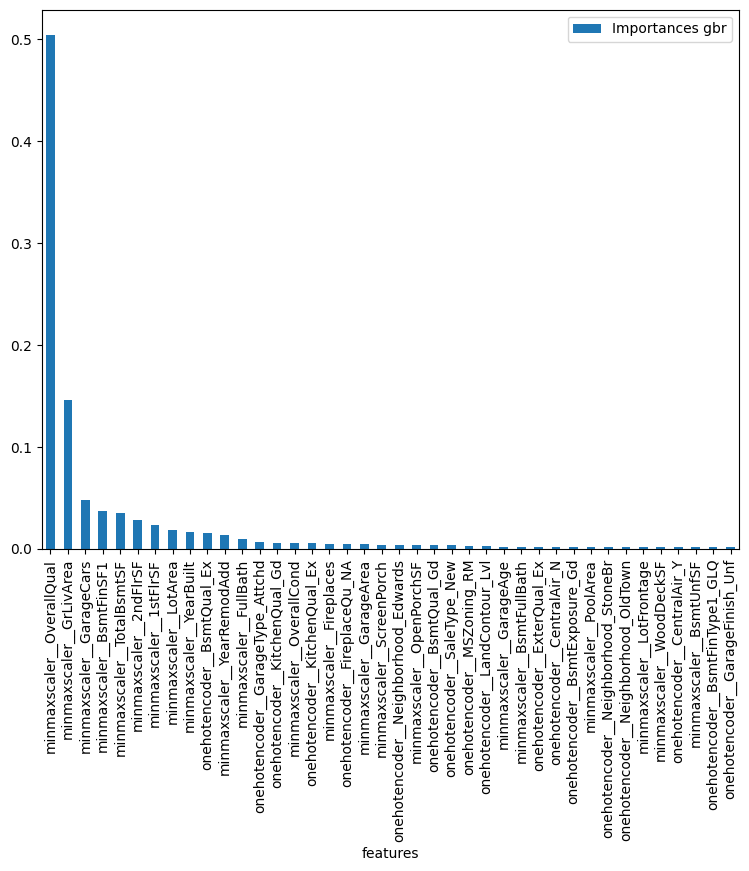

In [236]:
feature = pd.DataFrame(zip(trans_features, best_estimators['gbr'].feature_importances_), columns=['features', 'Importances gbr'])

feature.sort_values(by="Importances gbr", ascending=False).head(40).plot(x="features", kind='bar', figsize=(9, 7))

On remarque que la feature OverallQual est celle qui influence le plus la prédiction sur le prix.  
Dans la suite de ce notebook on va essayer de faire du feature engineering pour augmenter l'influence d'autres features.  
  
Pour la suite du notebook, on va comparer les données obtenuent, avec la fonction big_fit_def, pour le features engineering avec les données stockés dans le DataFrame result_initial_comparaison

## Feature  engineering

### Transformation des mois en saison

In [237]:
house_price_test = house_price_fillm.copy()

In [238]:
saison = ['Spring', 'Summer', 'Autumn', 'Winter']
month = [[3, 4, 5], [6, 7, 8], [9, 10, 11], [12, 1, 2]]
house_price_test.MoSold.replace(to_replace=month, value=saison, inplace=True)

In [239]:
df_train_numerical = [column for column in house_price_test.columns.values.tolist() if house_price_test[column].dtype != object]
df_train_numerical.remove('SalePrice')
df_train_categorical = [column for column in house_price_test.columns.values.tolist() if house_price_test[column].dtype == object]

transformer = make_column_transformer(
    (MinMaxScaler(), df_train_numerical),
    (OneHotEncoder(handle_unknown="infrequent_if_exist"), df_train_categorical)
)

df_train_X, df_train_y = (house_price_test.drop(["SalePrice"], axis=1), house_price_test["SalePrice"])
df_train_X_enc = transformer.fit_transform(df_train_X)

trans_features = transformer.get_feature_names_out()
print(f"{trans_features.size} features after trans")

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_train_X_enc, df_train_y, test_size=0.25, random_state=42)
default_errors, best_scores, errors, predict_errors, best_params, best_estimators = big_fit_def(X_train_base, y_train_base, X_test_base, y_test_base)

result_saison = pd.DataFrame({
    "Name": [e for e in best_estimators.keys()],
    "Default mea test score saison": [val['mea'] for val in default_errors.values()],
    "Default mse test score saison": [val['mse'] for val in default_errors.values()],
    "Default medae test score saison": [val['medae'] for val in default_errors.values()],
    "Default r2 test score saison": [val['r2'] for val in default_errors.values()],
    "Grid cross-val score saison": list(best_scores.values()),
    "Grid mea test score saison": [val['mea'] for val in predict_errors.values()],
    "Grid mse test score saison": [val['mse'] for val in predict_errors.values()],
    "Grid medae test score saison": [val['medae'] for val in predict_errors.values()],
    "Grid r2 test score saison": [val['r2'] for val in predict_errors.values()],
})
print("Train Finished! \o/")

306 features after trans
Trainning with gbr
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Trainning with rfr
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Train Finished! \o/


In [240]:
result_saison

,Name,Default mea test score saison,Default mse test score saison,Default medae test score saison,Default r2 test score saison,Grid cross-val score saison,Grid mea test score saison,Grid mse test score saison,Grid medae test score saison,Grid r2 test score saison
0,gbr,16033.317543,6.180427e+08,11700.88396,0.911775,79.89,15292.291485,6.103499e+08,9902.948019,0.912873
1,rfr,17147.296658,7.912796e+08,10160.98000,0.887046,80.44,16883.034475,7.513945e+08,9984.596667,0.892739


In [241]:
cols_ini = ["Name", "Grid cross-val score", "Grid r2 test score"]
cols_Saison = ["Name", "Grid cross-val score saison", "Grid r2 test score saison"]

results = pd.merge(result_initial_comparaison[cols_ini], result_saison[cols_Saison], on="Name")

In [242]:
results

,Name,Grid cross-val score,Grid r2 test score,Grid cross-val score saison,Grid r2 test score saison
0,gbr,79.82,0.906540,79.89,0.912873
1,rfr,80.64,0.895551,80.44,0.892739


Le changement de mois en saison diminue le r² score pour le randomForest, mais augmente légèrement celui du gradientBoosting. On peut négliger le changement en saisons dans la suite du features engineering.

### Transformation des types de logements en investissement

In [243]:
house_price_test = house_price_fillm.copy()

In [244]:
tlog = {
    20 : 2, 30: 0, 40: 1, 45: 0, 50: 1, 60: 3, 70: 2, 75: 2, 80: 2, 
    85: 1, 90: 1, 120: 3, 160: 1, 180: 0, 190: 1 
}

In [245]:
house_price_test['Investissement'] = house_price_test.MSSubClass.replace(tlog)
house_price_test.drop(['MSSubClass'], axis=1, inplace=True)

In [246]:
df_train_numerical = [column for column in house_price_test.columns.values.tolist() if house_price_test[column].dtype != object]
df_train_numerical.remove('SalePrice')
df_train_categorical = [column for column in house_price_test.columns.values.tolist() if house_price_test[column].dtype == object]

transformer = make_column_transformer(
    (MinMaxScaler(), df_train_numerical),
    (OneHotEncoder(handle_unknown="infrequent_if_exist"), df_train_categorical)
)

df_train_X, df_train_y = (house_price_test.drop(["SalePrice"], axis=1), house_price_test["SalePrice"])
df_train_X_enc = transformer.fit_transform(df_train_X)

trans_features = transformer.get_feature_names_out()
print(f"{trans_features.size} features after trans")

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_train_X_enc, df_train_y, test_size=0.25, random_state=42)
default_errors, best_scores, errors, predict_errors, best_params, best_estimators = big_fit_def(X_train_base, y_train_base, X_test_base, y_test_base)

result_invest = pd.DataFrame({
    "Name": [e for e in best_estimators.keys()],
    "Default mea test score invest": [val['mea'] for val in default_errors.values()],
    "Default mse test score invest": [val['mse'] for val in default_errors.values()],
    "Default medae test score invest": [val['medae'] for val in default_errors.values()],
    "Default r2 test score invest": [val['r2'] for val in default_errors.values()],
    "Grid cross-val score invest": list(best_scores.values()),
    "Grid mea test score invest": [val['mea'] for val in predict_errors.values()],
    "Grid mse test score invest": [val['mse'] for val in predict_errors.values()],
    "Grid medae test score invest": [val['medae'] for val in predict_errors.values()],
    "Grid r2 test score invest": [val['r2'] for val in predict_errors.values()],
})
print("Train Finished! \o/")

303 features after trans
Trainning with gbr
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Trainning with rfr
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Train Finished! \o/


In [247]:
result_invest

,Name,Default mea test score invest,Default mse test score invest,Default medae test score invest,Default r2 test score invest,Grid cross-val score invest,Grid mea test score invest,Grid mse test score invest,Grid medae test score invest,Grid r2 test score invest
0,gbr,16150.331904,6.159978e+08,10726.751678,0.912067,80.62,15302.203208,5.833332e+08,9702.513894,0.916730
1,rfr,16956.101753,7.739550e+08,9874.770000,0.889519,80.29,16718.509945,7.456201e+08,9844.246667,0.893564


In [248]:
cols_invest = ["Name", "Grid cross-val score invest", "Grid r2 test score invest"]

results = pd.merge(results, result_invest[cols_invest], on="Name")
results

,Name,Grid cross-val score,Grid r2 test score,Grid cross-val score saison,Grid r2 test score saison,Grid cross-val score invest,Grid r2 test score invest
0,gbr,79.82,0.906540,79.89,0.912873,80.62,0.916730
1,rfr,80.64,0.895551,80.44,0.892739,80.29,0.893564


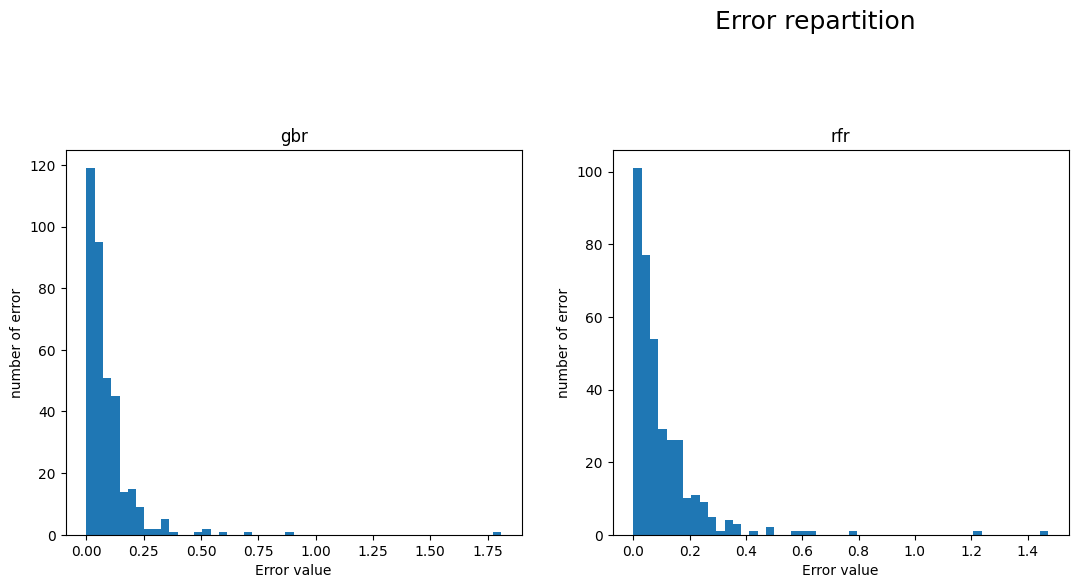

In [249]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Error repartition", fontsize=18, y=0.95)

i = 1
for name, error in errors.items():
    
    plt.subplot(3, 3, i)
    i += 1
    plt.title(f"{name}")
    plt.xlabel("Error value")
    plt.ylabel("number of error")

    plt.hist(error, bins=50)


plt.show()

<AxesSubplot: xlabel='features'>

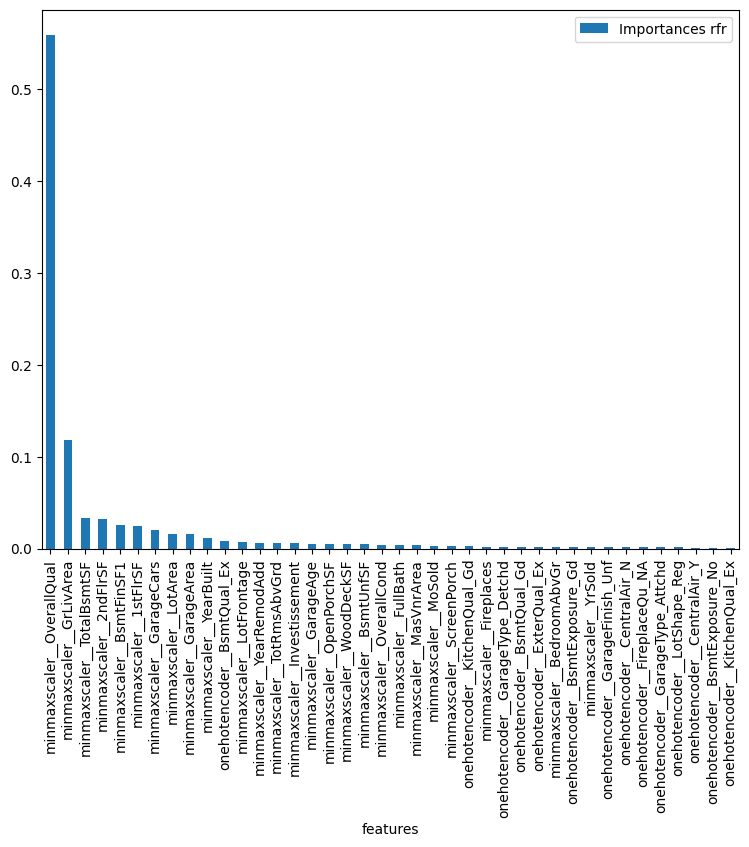

In [250]:
feature = pd.DataFrame(zip(trans_features, best_estimators['rfr'].feature_importances_), columns=['features', 'Importances rfr'])

feature.sort_values(by="Importances rfr", ascending=False).head(40).plot(x="features", kind='bar', figsize=(9, 7))

<AxesSubplot: xlabel='features'>

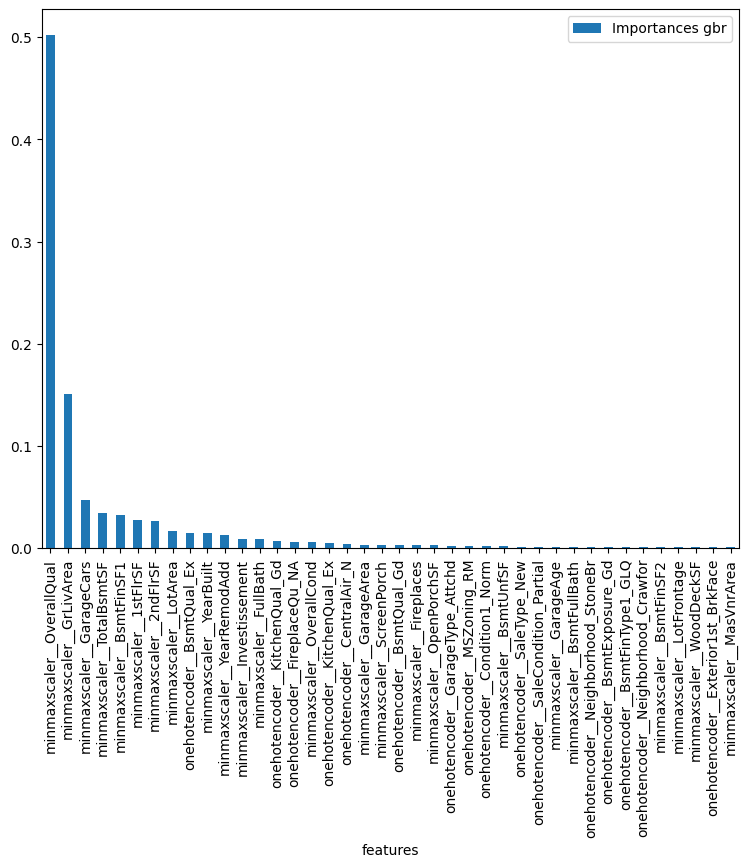

In [251]:
feature = pd.DataFrame(zip(trans_features, best_estimators['gbr'].feature_importances_), columns=['features', 'Importances gbr'])

feature.sort_values(by="Importances gbr", ascending=False).head(40).plot(x="features", kind='bar', figsize=(9, 7))

En comparant les deux histogrammes sur l'importance des features, on observe bien une augmentation de l'importance du type de logement après l'avoir transformé en investissement.  
Le gradienboosting évolue positivement avec le changement en investissement alors que le randomforest évolue négativement comme pour le changement en saison.

### Transformation du voisinage

In [252]:
house_price_test = house_price_fillm.copy()

In [253]:
nbh = {
    'MeadowV': 0, 'IDOTRR': 0, 'BrDale': 0, 'BrkSide': 0, 'Edwards': 0, 'OldTown': 0, 'Sawyer': 0, 'Blueste': 0,
    'SWISU': 1, 'NPkVill': 1, 'NAmes': 1, 'Mitchel': 1,
    'SawyerW': 2, 'NWAmes': 2, 'Gilbert': 2, 'Blmngtn': 2, 'CollgCr': 2, 'Crawfor': 2, 'ClearCr': 2,
    'Somerst': 3, 'Veenker': 3, 'Timber': 3,
    'StoneBr': 4, 'NridgHt': 4, 'NoRidge': 4
}

In [254]:
house_price_test.Neighborhood.replace(nbh, inplace=True)

In [255]:
df_train_numerical = [column for column in house_price_test.columns.values.tolist() if house_price_test[column].dtype != object]
df_train_numerical.remove('SalePrice')
df_train_categorical = [column for column in house_price_test.columns.values.tolist() if house_price_test[column].dtype == object]

transformer = make_column_transformer(
    (MinMaxScaler(), df_train_numerical),
    (OneHotEncoder(handle_unknown="infrequent_if_exist"), df_train_categorical)
)

df_train_X, df_train_y = (house_price_test.drop(["SalePrice"], axis=1), house_price_test["SalePrice"])
df_train_X_enc = transformer.fit_transform(df_train_X)

trans_features = transformer.get_feature_names_out()
print(f"{trans_features.size} features after trans")

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_train_X_enc, df_train_y, test_size=0.25, random_state=42)
default_errors, best_scores, errors, predict_errors, best_params, best_estimators = big_fit_def(X_train_base, y_train_base, X_test_base, y_test_base)

result_nbh = pd.DataFrame({
    "Name": [e for e in best_estimators.keys()],
    "Default mea test score voisin": [val['mea'] for val in default_errors.values()],
    "Default mse test score voisin": [val['mse'] for val in default_errors.values()],
    "Default medae test score voisin": [val['medae'] for val in default_errors.values()],
    "Default r2 test score voisin": [val['r2'] for val in default_errors.values()],
    "Grid cross-val score voisin": list(best_scores.values()),
    "Grid mea test score voisin": [val['mea'] for val in predict_errors.values()],
    "Grid mse test score voisin": [val['mse'] for val in predict_errors.values()],
    "Grid medae test score voisin": [val['medae'] for val in predict_errors.values()],
    "Grid r2 test score voisin": [val['r2'] for val in predict_errors.values()],
})
print("Train Finished! \o/")

279 features after trans
Trainning with gbr
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Trainning with rfr
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Train Finished! \o/


In [256]:
result_nbh

,Name,Default mea test score voisin,Default mse test score voisin,Default medae test score voisin,Default r2 test score voisin,Grid cross-val score voisin,Grid mea test score voisin,Grid mse test score voisin,Grid medae test score voisin,Grid r2 test score voisin
0,gbr,15916.078300,6.521156e+08,10845.193584,0.906911,82.11,15286.989675,6.253235e+08,9934.334346,0.910736
1,rfr,16742.800932,7.539801e+08,9192.550000,0.892370,81.00,16340.227735,7.304173e+08,9024.100000,0.895734


In [257]:
cols_voisin = ["Name", "Grid cross-val score voisin", "Grid r2 test score voisin"]

results = pd.merge(result_initial_comparaison[cols_ini], result_nbh[cols_voisin], on="Name")
results

,Name,Grid cross-val score,Grid r2 test score,Grid cross-val score voisin,Grid r2 test score voisin
0,gbr,79.82,0.906540,82.11,0.910736
1,rfr,80.64,0.895551,81.00,0.895734


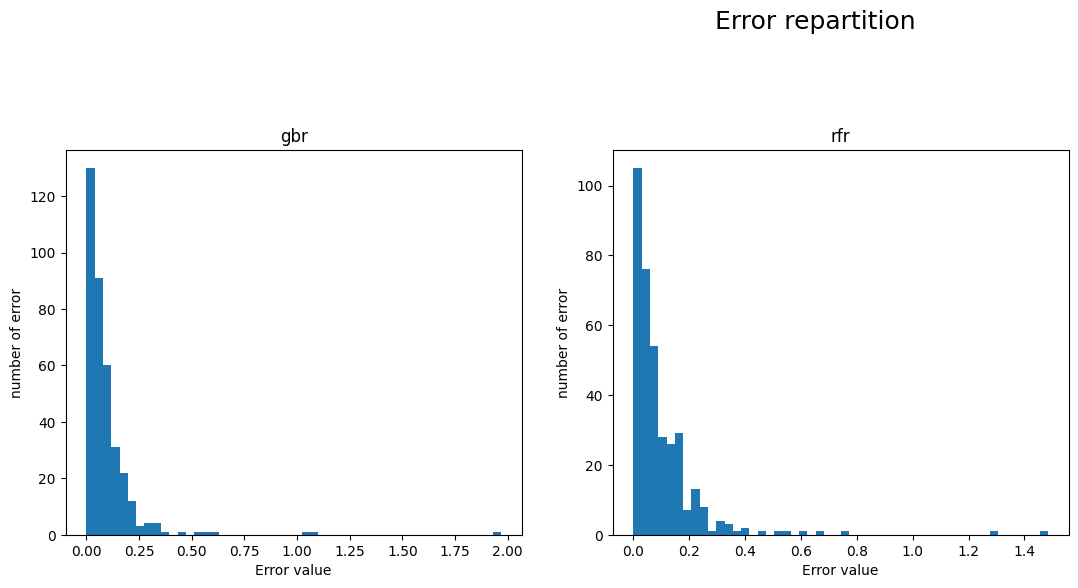

In [258]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Error repartition", fontsize=18, y=0.95)

i = 1
for name, error in errors.items():
    
    plt.subplot(3, 3, i)
    i += 1
    plt.title(f"{name}")
    plt.xlabel("Error value")
    plt.ylabel("number of error")

    plt.hist(error, bins=50)


plt.show()

<AxesSubplot: xlabel='features'>

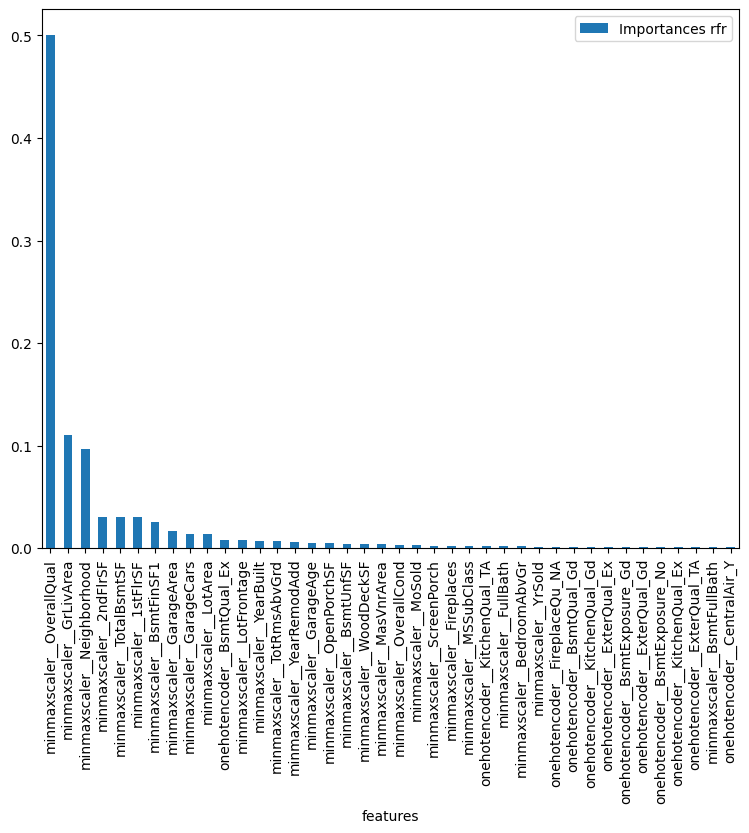

In [259]:
feature = pd.DataFrame(zip(trans_features, best_estimators['rfr'].feature_importances_), columns=['features', 'Importances rfr'])

feature.sort_values(by="Importances rfr", ascending=False).head(40).plot(x="features", kind='bar', figsize=(9, 7))

<AxesSubplot: xlabel='features'>

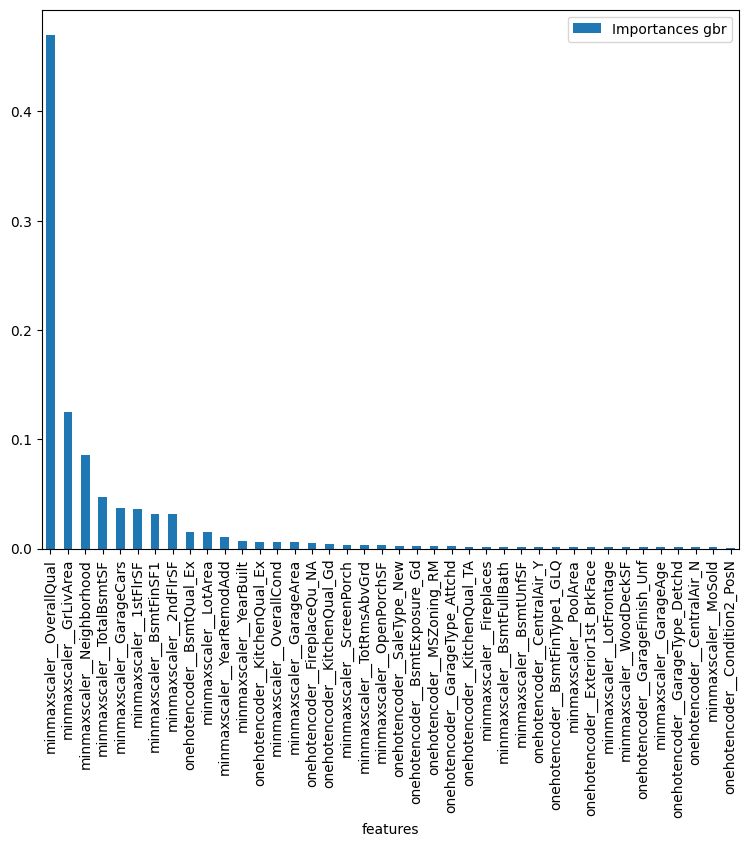

In [260]:
feature = pd.DataFrame(zip(trans_features, best_estimators['gbr'].feature_importances_), columns=['features', 'Importances gbr'])

feature.sort_values(by="Importances gbr", ascending=False).head(40).plot(x="features", kind='bar', figsize=(9, 7))

On remarque bien l'évoluton des deux modèls de régression utilisés ainsi que l'importance du voisinage suite à sa transformation parmi le degré d'importance des features.

### Transformation année de construction en tranche d'années de construction

In [261]:
house_price_test = house_price_fillm.copy()

In [262]:
taille_bin = [x for x in range(1870, 2011, 10)]
label_name = [str(x) for x in range(1870, 2010, 10)]
house_price_test['YrBltBand'] = pd.cut(house_price_test.YearBuilt, bins=taille_bin, labels=label_name)
house_price_test.drop(['YearBuilt'], axis=1, inplace= True)


In [263]:
df_train_numerical = [column for column in house_price_test.columns.values.tolist() if house_price_test[column].dtype != object]
df_train_numerical.remove('SalePrice')
df_train_numerical.remove('YrBltBand')
df_train_categorical = [column for column in house_price_test.columns.values.tolist() if house_price_test[column].dtype == object]
df_train_categorical.append('YrBltBand')

transformer = make_column_transformer(
    (MinMaxScaler(), df_train_numerical),
    (OneHotEncoder(handle_unknown="infrequent_if_exist"), df_train_categorical)
)

df_train_X, df_train_y = (house_price_test.drop(["SalePrice"], axis=1), house_price_test["SalePrice"])
df_train_X_enc = transformer.fit_transform(df_train_X)

trans_features = transformer.get_feature_names_out()
print(f"{trans_features.size} features after trans")

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_train_X_enc, df_train_y, test_size=0.25, random_state=42)
default_errors, best_scores, errors, predict_errors, best_params, best_estimators = big_fit_def(X_train_base, y_train_base, X_test_base, y_test_base)

result_yrband = pd.DataFrame({
    "Name": [e for e in best_estimators.keys()],
    "Default mea test score yrband": [val['mea'] for val in default_errors.values()],
    "Default mse test score yrband": [val['mse'] for val in default_errors.values()],
    "Default medae test score yrband": [val['medae'] for val in default_errors.values()],
    "Default r2 test score yrband": [val['r2'] for val in default_errors.values()],
    "Grid cross-val score yrband": list(best_scores.values()),
    "Grid mea test score yrband": [val['mea'] for val in predict_errors.values()],
    "Grid mse test score yrband": [val['mse'] for val in predict_errors.values()],
    "Grid medae test score yrband": [val['medae'] for val in predict_errors.values()],
    "Grid r2 test score yrband": [val['r2'] for val in predict_errors.values()],
})
print("Train Finished! \o/")

316 features after trans
Trainning with gbr
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Trainning with rfr
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Train Finished! \o/


In [264]:
result_yrband

,Name,Default mea test score yrband,Default mse test score yrband,Default medae test score yrband,Default r2 test score yrband,Grid cross-val score yrband,Grid mea test score yrband,Grid mse test score yrband,Grid medae test score yrband,Grid r2 test score yrband
0,gbr,16235.545981,7.039195e+08,11007.720969,0.899516,80.22,15375.161411,6.755100e+08,9677.601783,0.903572
1,rfr,16972.777205,7.765795e+08,9945.320000,0.889144,80.79,16762.951781,7.343068e+08,10058.103333,0.895179


In [265]:
cols_yrband = ["Name", "Grid cross-val score yrband", "Grid r2 test score yrband"]

results = pd.merge(result_initial_comparaison[cols_ini], result_yrband[cols_yrband], on="Name")
results

,Name,Grid cross-val score,Grid r2 test score,Grid cross-val score yrband,Grid r2 test score yrband
0,gbr,79.82,0.906540,80.22,0.903572
1,rfr,80.64,0.895551,80.79,0.895179


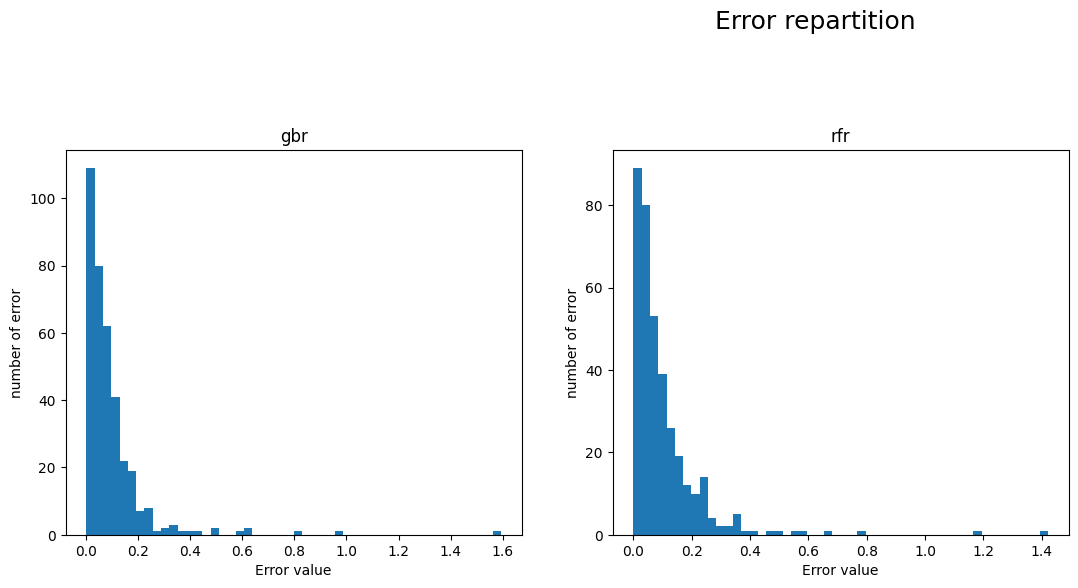

In [266]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Error repartition", fontsize=18, y=0.95)

i = 1
for name, error in errors.items():
    
    plt.subplot(3, 3, i)
    i += 1
    plt.title(f"{name}")
    plt.xlabel("Error value")
    plt.ylabel("number of error")

    plt.hist(error, bins=50)


plt.show()

Appliquons tous les changements que l'on a vu plus haut dans le notebook.  
Le dataFrame va contenir tous les changements.

### Regroupement des Transformations

In [267]:
house_price_final = house_price_fillm.copy()

In [268]:
saison = ['Spring', 'Summer', 'Autumn', 'Winter']
month = [[3, 4, 5], [6, 7, 8], [9, 10, 11], [12, 1, 2]]
house_price_final.MoSold.replace(to_replace=month, value=saison, inplace=True)

tlog = {
    20 : 2, 30: 0, 40: 1, 45: 0, 50: 1, 60: 3, 70: 2, 75: 2, 80: 2, 
    85: 1, 90: 1, 120: 3, 160: 1, 180: 0, 190: 1 
}
house_price_final['Investissement'] = house_price_final.MSSubClass.replace(tlog)
house_price_final.drop(['MSSubClass'], axis=1, inplace=True)

nbh = {
    'MeadowV': 0, 'IDOTRR': 0, 'BrDale': 0, 'BrkSide': 0, 'Edwards': 0, 'OldTown': 0, 'Sawyer': 0, 'Blueste': 0,
    'SWISU': 1, 'NPkVill': 1, 'NAmes': 1, 'Mitchel': 1,
    'SawyerW': 2, 'NWAmes': 2, 'Gilbert': 2, 'Blmngtn': 2, 'CollgCr': 2, 'Crawfor': 2, 'ClearCr': 2,
    'Somerst': 3, 'Veenker': 3, 'Timber': 3,
    'StoneBr': 4, 'NridgHt': 4, 'NoRidge': 4
}

house_price_final.Neighborhood.replace(nbh, inplace=True)

taille_bin = [x for x in range(1870, 2011, 10)]
label_name = [str(x) for x in range(1870, 2010, 10)]
house_price_final['YrBltBand'] = pd.cut(house_price_final.YearBuilt, bins=taille_bin, labels=label_name)
house_price_final.drop(['YearBuilt'], axis=1, inplace= True)

In [269]:
df_train_numerical = [column for column in house_price_final.columns.values.tolist() if house_price_final[column].dtype != object]
df_train_numerical.remove('SalePrice')
df_train_numerical.remove('YrBltBand')
df_train_categorical = [column for column in house_price_final.columns.values.tolist() if house_price_final[column].dtype == object]
df_train_categorical.append('YrBltBand')

transformer = make_column_transformer(
    (MinMaxScaler(), df_train_numerical),
    (OneHotEncoder(handle_unknown="infrequent_if_exist"), df_train_categorical)
)

df_train_X, df_train_y = (house_price_final.drop(["SalePrice"], axis=1), house_price_final["SalePrice"])
df_train_X_enc = transformer.fit_transform(df_train_X)

trans_features = transformer.get_feature_names_out()
print(f"{trans_features.size} features after trans")

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_train_X_enc, df_train_y, test_size=0.25, random_state=42)
default_errors, best_scores, errors, predict_errors, best_params, best_estimators = big_fit_def(X_train_base, y_train_base, X_test_base, y_test_base)

result_final_wo_drop = pd.DataFrame({
    "Name": [e for e in best_estimators.keys()],
    "Default mea test score final_wo_drop": [val['mea'] for val in default_errors.values()],
    "Default mse test score final_wo_drop": [val['mse'] for val in default_errors.values()],
    "Default medae test score final_wo_drop": [val['medae'] for val in default_errors.values()],
    "Default r2 test score final_wo_drop": [val['r2'] for val in default_errors.values()],
    "Grid cross-val score final_wo_drop": list(best_scores.values()),
    "Grid mea test score final_wo_drop": [val['mea'] for val in predict_errors.values()],
    "Grid mse test score final_wo_drop": [val['mse'] for val in predict_errors.values()],
    "Grid medae test score final_wo_drop": [val['medae'] for val in predict_errors.values()],
    "Grid r2 test score final_wo_drop": [val['r2'] for val in predict_errors.values()],
})
print("Train Finished! \o/")

295 features after trans
Trainning with gbr
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Trainning with rfr
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Train Finished! \o/


In [270]:
result_final_wo_drop

,Name,Default mea test score final_wo_drop,Default mse test score final_wo_drop,Default medae test score final_wo_drop,Default r2 test score final_wo_drop,Grid cross-val score final_wo_drop,Grid mea test score final_wo_drop,Grid mse test score final_wo_drop,Grid medae test score final_wo_drop,Grid r2 test score final_wo_drop
0,gbr,16081.672634,6.831087e+08,10785.911291,0.902487,82.41,15653.822379,6.630357e+08,9964.155849,0.905352
1,rfr,16720.611507,7.501972e+08,9552.870000,0.892910,81.44,16388.521562,7.226132e+08,9454.306667,0.896848


In [271]:
result_initial_comparaison

,Name,Default mea test score,Default mse test score,Default medae test score,Default r2 test score,Grid cross-val score,Grid mea test score,Grid mse test score,Grid medae test score,Grid r2 test score
0,gbr,16283.708300,6.686908e+08,11503.16545,0.904545,79.82,15470.692377,6.547152e+08,10083.796137,0.906540
1,rfr,16983.883397,7.604994e+08,10237.50000,0.891440,80.64,16729.303288,7.316990e+08,9702.393333,0.895551


In [272]:
cols_final_wo_drop = ["Name", "Grid cross-val score final_wo_drop", "Grid r2 test score final_wo_drop"]

results = pd.merge(result_initial_comparaison[cols_ini], result_final_wo_drop[cols_final_wo_drop], on="Name")
results

,Name,Grid cross-val score,Grid r2 test score,Grid cross-val score final_wo_drop,Grid r2 test score final_wo_drop
0,gbr,79.82,0.906540,82.41,0.905352
1,rfr,80.64,0.895551,81.44,0.896848


Computing learning curve of gbr


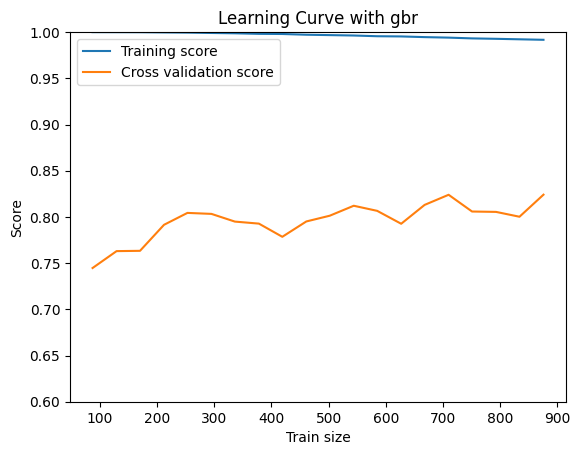

In [273]:
plot_learning_curve('gbr', best_estimators['gbr'], X_train_base, y_train_base)

Computing learning curve of rfr


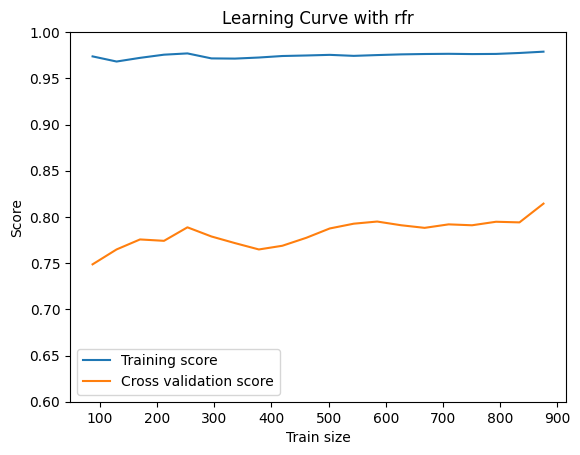

In [274]:
plot_learning_curve('rfr', best_estimators['rfr'], X_train_base, y_train_base)

On retombe sur les des courbes de learning curves quasi identiques aux premières sorties.

Les changements réfléchis ont permis une amélioration du grid search cv score, mais sans amélirations significatives sur les autres métriques.  
  
Pour des pistes d'améliorations, on pourrait drop certaines colonnes dont l'influence sur le prix de vente dans la matrice de corrélation est négligeable ainsi que les colonnes dont le features_importances est trop petit.